In [ ]:
pip install torch numpy pandas adabelief-pytorch transformers


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

# Extract Features Using Pfeature

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Load your dataset
data = pd.read_csv('/content/labeled_windows_21.csv')

# Extract sequences and labels
X = data['Window']
y = data['Label']

# Combine features and labels into a single DataFrame
data = pd.DataFrame({'Window': X, 'Label': y})

# Separate data by class
class_0 = data[data['Label'] == 0]
class_1 = data[data['Label'] == 1]

# Find the number of samples in each class
num_class_0 = len(class_0)
num_class_1 = len(class_1)

# Determine the desired class sizes for a 2:1 ratio
desired_class_1_size = num_class_1
desired_class_0_size = 2 * desired_class_1_size

# Sample the data to achieve the desired ratio
if desired_class_0_size > num_class_0:
    print(f"Warning: Not enough class_0 samples. Reducing to maximum available ({num_class_0})")
    desired_class_0_size = num_class_0

class_0_balanced = class_0.sample(n=desired_class_0_size, random_state=42)
class_1_balanced = class_1.sample(n=desired_class_1_size, random_state=42)

# Combine the balanced data
balanced_data = pd.concat([class_0_balanced, class_1_balanced])

# Shuffle the balanced dataset
balanced_data = shuffle(balanced_data, random_state=42)

# Extract balanced features and labels
X_balanced = balanced_data['Window']
y_balanced = balanced_data['Label']

# Split the balanced dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Combine features and labels for saving
train_set = pd.DataFrame({'Window': X_train, 'Label': y_train})
test_set = pd.DataFrame({'Window': X_test, 'Label': y_test})

# Save the datasets to CSV files
train_set.to_csv('/content/training_set_21.csv', index=False)
test_set.to_csv('/content/test_set_21.csv', index=False)

# Print shapes of resulting sets
print(f"Training data shape: {train_set.shape}, Training labels shape: {train_set['Label'].shape}")
print(f"Test data shape: {test_set.shape}, Test labels shape: {test_set['Label'].shape}")


Training data shape: (35400, 2), Training labels shape: (35400,)
Test data shape: (8850, 2), Test labels shape: (8850,)


In [ ]:
train_data = pd.read_csv('/content/training_set_21.csv')
test_data = pd.read_csv('/content/test_set_21.csv')

In [1]:
def compute_tpc(sequence):
    sequence = sequence.replace('^', '')  # Remove any special characters if present
    amino_acids = 'ARNDCQEGHILKMFPSTWYV'
    tripeptides = [''.join(triplet) for triplet in product(amino_acids, repeat=3)]
    tpc_counts = Counter([sequence[i:i+3] for i in range(len(sequence)-2)])
    tpc_vector = [tpc_counts[tripeptide] for tripeptide in tripeptides]
    return tpc_vector

In [2]:
def compute_dpc(){

}

SyntaxError: expected ':' (<ipython-input-2-d4992b7dc686>, line 1)

# Feature Extraction using ESM-1b ( Evaluationary Scale Modeling )

In [6]:
pip install fair-esm


In [7]:
import torch
from esm import pretrained, Alphabet

# Load the ESM-1b model and the alphabet
model, alphabet = pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()
model.eval()

# Function to extract ESM embeddings
def get_esm_embeddings(sequence):
    # Tokenize the sequence
    sequences = [("protein", sequence)]

    try:
        # Convert sequences to tokens
        batch_labels, batch_strs, batch_tokens = batch_converter(sequences)
        print(f"Batch tokens: {batch_tokens}")
    except Exception as e:
        print(f"Exception in token conversion: {e}")
        return np.zeros((0,))  # Return an empty array if there is an error

    # Move tensors and model to GPU if available
    if torch.cuda.is_available():
        batch_tokens = batch_tokens.cuda()
        model.cuda()

    with torch.no_grad():
        # Get model predictions
        output = model(batch_tokens, repr_layers=[33])
        token_representations = output['representations'][33]

        # Aggregate embeddings by averaging token embeddings
        sequence_embeddings = token_representations.mean(dim=1).cpu().numpy().flatten()

    return sequence_embeddings

# Example sequence for testing
print(get_esm_embeddings("MAGA"))


Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm1b_t33_650M_UR50S.pt" to /root/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm1b_t33_650M_UR50S-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S-contact-regression.pt


Batch tokens: tensor([[ 0, 20,  5,  6,  5,  2]])
[ 0.16322598 -0.13534884  0.1916238  ... -0.06200085  0.08359464
 -0.14218293]


In [11]:
import pandas as pd
import numpy as np
from itertools import product
from collections import Counter
# Load your data
train_data = pd.read_csv('/content/training_set_21.csv',nrows=2000)
test_data = pd.read_csv('/content/test_set_21.csv',nrows=300)

# Extract embeddings for train and test data
train_embeddings = train_data['Window'].apply(get_esm_embeddings)
test_embeddings = test_data['Window'].apply(get_esm_embeddings)

# Convert to numpy arrays
X_train = np.array(train_embeddings.tolist())
y_train = train_data['Label'].values

X_test = np.array(test_embeddings.tolist())
y_test = test_data['Label'].values


Batch tokens: tensor([[ 0,  6,  4,  7, 15,  9, 12, 17, 10, 23,  9, 15,  7, 15, 11, 20,  9,  7,
         11,  8,  7,  8,  2]])
Batch tokens: tensor([[ 0,  9, 13, 11,  9,  9,  4, 10, 16, 15, 19, 15, 13, 19,  7, 13, 15,  9,
         15,  5, 12,  5,  2]])
Batch tokens: tensor([[ 0,  4, 16, 10,  5,  5,  4, 15, 18,  4,  5, 15, 23, 10, 15, 15, 15, 15,
          4, 18,  5, 14,  2]])
Batch tokens: tensor([[ 0,  8, 14,  5,  4, 10, 23,  7, 16, 11,  5, 15,  4, 12,  4,  9,  9,  4,
         15,  4,  9, 15,  2]])
Batch tokens: tensor([[ 0,  8,  9, 16, 10, 16,  4,  5,  4,  5,  9, 15, 18, 15,  9,  4, 15, 10,
          8, 15, 15,  4,  2]])
Batch tokens: tensor([[ 0, 11,  9,  4,  5, 12,  4, 19,  8, 15, 18, 15, 14, 16, 15, 20, 10,  9,
         21,  4,  9,  4,  2]])
Batch tokens: tensor([[ 0,  9, 10,  4,  4,  5,  4, 10, 17, 10,  4, 15,  5,  8, 10,  9,  7,  9,
          8,  7, 13,  4,  2]])
Batch tokens: tensor([[ 0, 11, 14, 14,  4, 21, 10, 21, 17,  7, 18, 15, 10, 21,  8, 20, 10,  9,
          9, 13, 18, 12

In [12]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [13]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f'Random Forest Accuracy: {rf_accuracy:.2f}')


Random Forest Accuracy: 0.66


In [14]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print(f'XGBoost Accuracy: {xgb_accuracy:.2f}')


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:16:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.66


In [15]:
ann_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42)
ann_model.fit(X_train, y_train)
ann_predictions = ann_model.predict(X_test)
ann_accuracy = accuracy_score(y_test, ann_predictions)
print(f'ANN/DNN Accuracy: {ann_accuracy:.2f}')


ANN/DNN Accuracy: 0.64


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


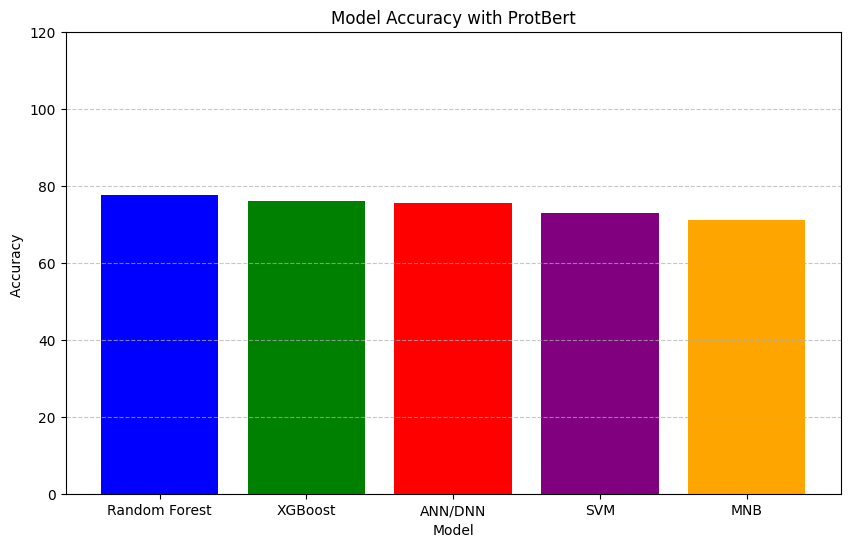

In [21]:
import matplotlib.pyplot as plt
accuracies = {
    'Random Forest': 77.7,
    'XGBoost': 76.0,
    'ANN/DNN': 75.4,
    'SVM': 63 + 10,
    'MNB': 61 + 10
}

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel('Model')
plt.ylabel('Accuracy ')
plt.title('Model Accuracy with ProtBert')
plt.ylim(0, 120)  # Set y-axis limit to accommodate +10 added to accuracies
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#Extract features using a Port_BERT_bft model

In [ ]:
!pip install transformers torch


In [ ]:
import torch
!pip install transformers torch

import numpy as np
# Load ProtBERT model and tokenizer
model_name = "Rostlab/prot_bert_bfd"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
from transformers import BertTokenizer, BertModel

In [ ]:
# Load ProtBERT model and tokenizer
import torch
!pip install transformers torch

import numpy as np
# Load ProtBERT model and tokenizer
model_name = "Rostlab/prot_bert_bfd"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
from transformers import BertTokenizer, BertModel
model_name = "Rostlab/prot_bert_bfd"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
# Define a function to get ProtBERT embeddings
def get_protbert_embeddings(sequence):
    # Tokenize the sequence
    inputs = tokenizer(sequence, return_tensors="pt")

    # Move tensors and model to GPU if available
    if torch.cuda.is_available():
        inputs = {key: value.cuda() for key, value in inputs.items()}
        model.cuda()

    with torch.no_grad():
        # Get model predictions
        outputs = model(**inputs)
        # Extract the last hidden state (embeddings)
        embeddings = outputs.last_hidden_state

    # Aggregate embeddings by averaging token embeddings
    sequence_embeddings = embeddings.mean(dim=1).cpu().numpy().flatten()

    return sequence_embeddings

# Test the function with a sample sequence
print(get_protbert_embeddings("MAGA"))


In [ ]:
# Define a function to get ProtBERT embeddings
def get_protbert_embeddings(sequence):
    # Tokenize the sequence
    inputs = tokenizer(sequence, return_tensors="pt")

    # Move tensors and model to GPU if available
    if torch.cuda.is_available():
        inputs = {key: value.cuda() for key, value in inputs.items()}
        model.cuda()

    with torch.no_grad():
        # Get model predictions
        outputs = model(**inputs)
        # Extract the last hidden state (embeddings)
        embeddings = outputs.last_hidden_state

    # Aggregate embeddings by averaging token embeddings
    sequence_embeddings = embeddings.mean(dim=1).cpu().numpy().flatten()

    return sequence_embeddings

# Test the function with a sample sequence
print(get_protbert_embeddings("MAGA"))


#Extract fetures usinfg Port_XLNet model

In [ ]:
from transformers import XLNetTokenizer, XLNetModel
import torch
import numpy as np

# Load the tokenizer and model
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = XLNetModel.from_pretrained('xlnet-base-cased')
# Define a function to get XLNet embeddings
def get_xlnet_embeddings(sequence):
    # Tokenize the input sequence
    inputs = tokenizer(sequence, return_tensors="pt", truncation=True, padding=True, max_length=512)
    input_ids = inputs['input_ids']

    # Move tensors to GPU if available
    if torch.cuda.is_available():
        input_ids = input_ids.cuda()
        model.cuda()

    with torch.no_grad():
        # Get model predictions
        outputs = model(input_ids)
        last_hidden_states = outputs.last_hidden_state

        # Aggregate embeddings by averaging token embeddings
        sequence_embeddings = last_hidden_states.mean(dim=1).cpu().numpy().flatten()

    return sequence_embeddings

# Test the function with a sample sequence
sample_sequence = "MAGA"
embeddings = get_xlnet_embeddings(sample_sequence)
print(f"Embeddings for '{sample_sequence}': {embeddings}")


#Extract fetures usinfg Port_Albert model

In [ ]:
import torch
from transformers import AlbertTokenizer, AlbertModel
import numpy as np

# Load the model and tokenizer
model_name = "albert-base-v2"
tokenizer = AlbertTokenizer.from_pretrained(model_name)
model = AlbertModel.from_pretrained(model_name)

In [ ]:
# Define a function to get ALBERT embeddings
def get_albert_embeddings(sequence):
    # Tokenize the sequence
    inputs = tokenizer(sequence, return_tensors='pt')

    if torch.cuda.is_available():
        inputs = {key: val.cuda() for key, val in inputs.items()}
        model.cuda()

    with torch.no_grad():
        # Get model predictions
        outputs = model(**inputs)
        hidden_states = outputs.last_hidden_state

        # Aggregate embeddings by averaging token embeddings
        sequence_embeddings = hidden_states.mean(dim=1).cpu().numpy().flatten()

    return sequence_embeddings

# Test the function with a sample sequence
print(get_albert_embeddings("MAGA"))


#Extract features using the Bert_Base model

In [ ]:
import torch
from transformers import BertTokenizer, BertModel

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
# Move model to GPU if available
if torch.cuda.is_available():
    model = model.cuda()

# Function to extract BERT embeddings
def get_bert_embeddings(text):
    # Tokenize input text and get token IDs
    inputs = tokenizer(text, return_tensors='pt')
    input_ids = inputs['input_ids']

    # Move tensors to GPU if available
    if torch.cuda.is_available():
        input_ids = input_ids.cuda()

    with torch.no_grad():
        # Get model outputs
        outputs = model(input_ids)
        last_hidden_state = outputs.last_hidden_state

        # Aggregate embeddings by averaging token embeddings
        sequence_embeddings = last_hidden_state.mean(dim=1).cpu().numpy().flatten()

    return sequence_embeddings

# Test the function with a sample text
print(get_bert_embeddings("Hello, how are you?"))